In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=9a9d4c66485c5d795ca0ccc91c3217261c5902a79f306eec23d0fa2f3ecb7a21
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [46]:
from pyspark.sql import SparkSession
from  math import sqrt
from numpy import array
import random

In [6]:
sqlContext = SparkSession.builder\
        .master("local")\
        .appName("FIFA22")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


In [59]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
# Load the data from the csv file
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('players_22_pca.csv')

# Select the columns you want to use for clustering
feature_cols = ['{}'.format(i) for i in range(3)]
data = data.select(*feature_cols)

# Create a vector assembler object to combine all the feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembler_data = assembler.transform(data)

# Determine the suitable number of clusters
wcss = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(assembler_data)
    wcss.append(model.summary.trainingCost)

In [60]:
assembler_data.show()

+------------------+------------------+--------------------+--------------------+
|                 0|                 1|                   2|            features|
+------------------+------------------+--------------------+--------------------+
|17.804954101027302|  5.38677033066677|   8.427475406063943|[17.8049541010273...|
| 17.96424719661613| 8.829445610981788|    2.70040335662087|[17.9642471966161...|
|17.369900431200534|  5.82013526479337|   1.447483756615212|[17.3699004312005...|
|20.156029308635574| 5.655294031370544|  3.8189583275182546|[20.1560293086355...|
|20.227779847110725|10.058882456784323|  1.6640721927705953|[20.2277798471107...|
|21.045342253178912| 7.655369618945598|  2.5481292006294347|[21.0453422531789...|
|18.155404192647293| 9.916555846518474|  0.8012326416634536|[18.1554041926472...|
|11.407609611384212|11.272017247015771|   3.943044536447828|[11.4076096113842...|
|14.214732177960878| 6.269464287548745|   8.004226800568018|[14.2147321779608...|
| 17.76249922890

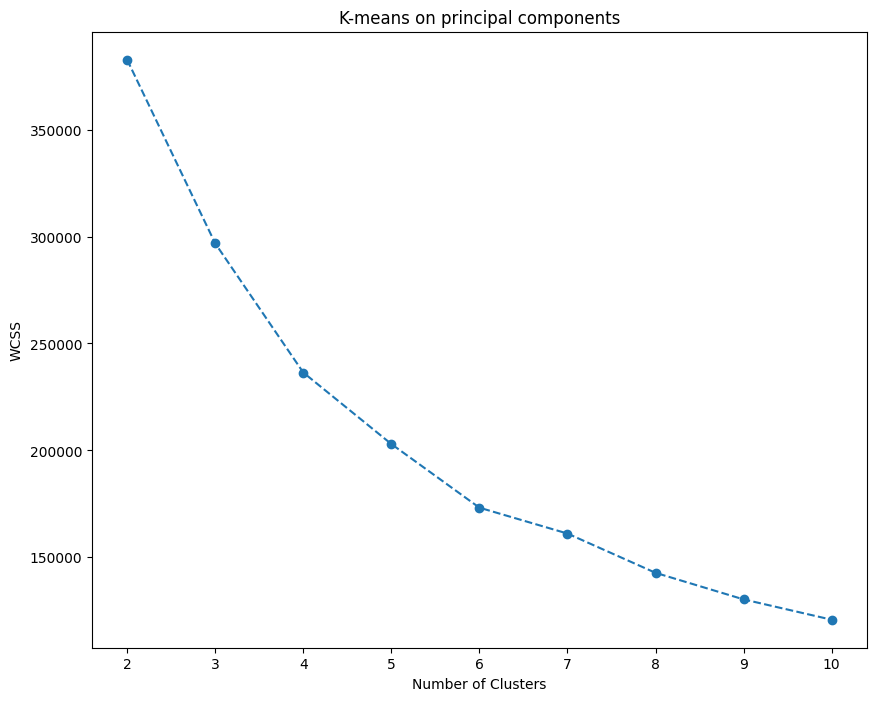

In [61]:
plt.figure(figsize=(10,8))
plt.plot(range(2,11),wcss,marker='o',linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-means on principal components")
plt.show()

In [78]:
# Convert the DataFrame to an RDD of numpy arrays
parsedData = data.rdd.map(lambda row: array([row[i] for i in range(3)]))

# Set the number of centroids
k = 4

# Initialize the centroids randomly
centroids = parsedData.takeSample(False, k, random.randint(1, 100))

# Function to compute the closest centroid for a data point
def closestCentroid(point):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centroids)):
        tempDist = sqrt(sum([x**2 for x in (point-centroids[i])]))
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return (bestIndex, (point, 1))

# Function to compute the new centroid
def computeNewCentroid(data):
    newCentroid = data[1][0]/data[1][1]
    return (data[0], newCentroid)

for i in range(10):
    # Assign each data point to the closest centroid
    closest = parsedData.map(closestCentroid)
    # Compute the new centroids by averaging the data points assigned to each centroid
    newCentroids = closest.reduceByKey(lambda x,y : (x[0]+y[0], x[1]+y[1])).map(computeNewCentroid).collect()
    # Update the centroids
    for newCentroid in newCentroids:
        centroids[newCentroid[0]] = newCentroid[1]

print("Final centroids: " + str(centroids))

Final centroids: [array([-1.29722521, -3.17841353,  1.75954492]), array([1.73512405, 2.20309031, 2.54238377]), array([-4.83063743,  1.82597351, -0.89364229]), array([ 4.05852427, -0.63048045, -2.67996853])]


In [79]:
cluster_count = closest.map(lambda x: (x[0], 1)).reduceByKey(lambda x,y : x+y).collect()

In [80]:
cluster_count

[(1, 3490), (3, 4589), (2, 4103), (0, 3838)]

In [81]:
closest_points = closest.map(lambda x: (x[0], x[1][0])).collect()

In [ ]:
from pyspark.sql import Row
from pyspark.sql.functions import col
# Convert RDD to list of Row objects
closest_points_rows = [Row(cluster=x[0], features=[float(f) for f in x[1]]) for x in closest_points]

# Create DataFrame from list of Row objects
closest_points_df = sqlContext.createDataFrame(closest_points_rows)

# Show DataFrame
closest_points_df.show()
clusters = closest_points_df.select('cluster', 'features')
for i in range(3):
    clusters = clusters.withColumn(f'feature_{i}', col('features')[i])

# Drop the original 'features' column
clusters = clusters.drop('features')

# Show the updated DataFrame
clusters.show()


In [ ]:
closest_points

In [ ]:
# Use KMeans from pyspark.ml.clustering
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(assembler_data.select('features'))
transformed = model.transform(assembler_data)
transformed.show()

In [ ]:
model.transform(assembler_data).groupBy('prediction').count().show()

In [101]:
# Plot the data points with colored regions according to the centroid they belong to
from mpl_toolkits import mplot3d
import plotly.express as px
clusters_pd = clusters.toPandas()
x_axis = clusters_pd['feature_0']
y_axis = clusters_pd['feature_1']
z_axis = clusters_pd['feature_2']
fig = px.scatter_3d(data_frame=clusters_pd,x=x_axis, y=y_axis, z=z_axis, color='cluster')
fig.add_scatter3d(x=[centroids[i][0] for i in range(k)], y=[centroids[i][1] for i in range(k)], z=[centroids[i][2] for i in range(k)], mode='markers', marker=dict(color='black', size=10))
fig.show()
